In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt


#read in + edit SP 500 value
sp500_df = pd.read_csv("sp500adj.csv")
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])
sp500_df['date_month'] = sp500_df['Date'].dt.strftime('%Y.%m')
sp500_df = sp500_df.rename(columns={"Value":"SP500 Index Value ($)"})
#sp500_df


#read in + edit geopolitical risk (GPR)
#"Higher geopolitical risk foreshadows lower investment, stock prices, and employment"
gpr_df_raw = pd.read_csv("data_gpr_export.csv")
gpr_df_raw['Date'] = pd.to_datetime(gpr_df_raw['month'])
gpr_df_raw['date_month'] = gpr_df_raw['Date'].dt.strftime('%Y.%m')
us_gpr_df = gpr_df_raw[['date_month','GPRC_USA']]


#read in + edit GDP with inflation adjusted
#note: had to remove first two lines in the dataset in order to actually read it
#those only contained the data source and last edit time:
#"Data Source","World Development Indicators",
#"Last Updated Date","2025-10-07",
GDP_df = pd.read_csv("GDP/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_130122.csv")
GDP_df = GDP_df[GDP_df['Country Code'] == 'USA']
gdp_usa = GDP_df.melt(
    id_vars=['Country Code','Country Name','Indicator Name','Indicator Code'],
    var_name='Year', value_name='GDP'
)
gdp_usa = gdp_usa.rename(columns={"GDP":"US GDP inflation adjusted ($)"})
gdp_usa = gdp_usa[gdp_usa['Year'].str.isnumeric()].copy()
gdp_usa['Year'] = gdp_usa['Year'].astype(int)
#gdp_usa


#read in + edit federal funds rate
fed_df = pd.read_csv("FEDFUNDS.csv")
fed_df['observation_date'] = pd.to_datetime(fed_df['observation_date'])
fed_df['Year'] = fed_df['observation_date'].dt.year
fed_df['FEDFUNDS'] = pd.to_numeric(fed_df['FEDFUNDS'], errors='coerce')
fed_df = fed_df.groupby('Year', as_index=False)['FEDFUNDS'].mean()


#read in + edit CPI (Consumer Price Index)
cpi_df = pd.read_csv("CPIAUCSL.csv")
cpi_df['observation_date'] = pd.to_datetime(cpi_df['observation_date'])
cpi_df['Year'] = cpi_df['observation_date'].dt.year
cpi_df['CPIAUCSL'] = pd.to_numeric(cpi_df['CPIAUCSL'], errors='coerce')
cpi_df = cpi_df.groupby('Year', as_index=False)['CPIAUCSL'].mean()
cpi_df = cpi_df.rename(columns={"CPIAUCSL":"CPI"})


#read in + edit unemployment rate
unrate_df = pd.read_csv("UNRATE.csv")
unrate_df['observation_date'] = pd.to_datetime(unrate_df['observation_date'])
unrate_df['Year'] = unrate_df['observation_date'].dt.year
unrate_df['UNRATE'] = pd.to_numeric(unrate_df['UNRATE'], errors='coerce')
unrate_df = unrate_df.groupby('Year', as_index=False)['UNRATE'].mean()
unrate_df = unrate_df.rename(columns={"UNRATE":"UNEMPLOYMENT RATE"})


#read in + edit VIX (Volatility Index)
vix_df = pd.read_csv("VIXCLS.csv")
vix_df['observation_date'] = pd.to_datetime(vix_df['observation_date'])
vix_df['Year'] = vix_df['observation_date'].dt.year
vix_df['VIXCLS'] = pd.to_numeric(vix_df['VIXCLS'], errors='coerce')
vix_df = vix_df.groupby('Year', as_index=False)['VIXCLS'].mean()
vix_df = vix_df.rename(columns={"VIXCLS":"VIX"})


#merging all the dataframes (by year)
merged_df = pd.merge(sp500_df, us_gpr_df, on='date_month', how='inner').dropna()
merged_df['Year'] = merged_df['Date'].dt.year
annual_df = merged_df.groupby('Year', as_index=False).agg({
    'SP500 Index Value ($)': 'mean',
    'GPRC_USA': 'mean'
})
merged_yearly_df = pd.merge(annual_df, gdp_usa[['Year','US GDP inflation adjusted ($)']], on='Year', how='inner')
merged_yearly_df = pd.merge(merged_yearly_df, fed_df, on='Year', how='left')
merged_yearly_df = pd.merge(merged_yearly_df, cpi_df, on='Year', how='left')
merged_yearly_df = pd.merge(merged_yearly_df, unrate_df, on='Year', how='left')
merged_yearly_df = pd.merge(merged_yearly_df, vix_df, on='Year', how='left')
#merged_yearly_df


#merging all the datasets (by year + month, doesn't include GDP)
merged_df = pd.merge(sp500_df, us_gpr_df, on='date_month', how='inner').dropna()
fed_df = pd.read_csv("FEDFUNDS.csv")
fed_df['observation_date'] = pd.to_datetime(fed_df['observation_date'])
fed_df['date_month'] = fed_df['observation_date'].dt.strftime('%Y.%m')
fed_df = fed_df[['date_month', 'FEDFUNDS']]
merged_monthly_df = pd.merge(merged_df, fed_df, on='date_month', how='left')

#read in + edit CPI for monthly merge
cpi_df_monthly = pd.read_csv("CPIAUCSL.csv")
cpi_df_monthly['observation_date'] = pd.to_datetime(cpi_df_monthly['observation_date'])
cpi_df_monthly['date_month'] = cpi_df_monthly['observation_date'].dt.strftime('%Y.%m')
cpi_df_monthly['CPIAUCSL'] = pd.to_numeric(cpi_df_monthly['CPIAUCSL'], errors='coerce')
cpi_df_monthly = cpi_df_monthly.groupby('date_month', as_index=False)['CPIAUCSL'].mean()
cpi_df_monthly = cpi_df_monthly.rename(columns={"CPIAUCSL":"CPI"})
cpi_df_monthly = cpi_df_monthly[['date_month', 'CPI']]

#read in + edit unemployment rate for monthly merge
unrate_df_monthly = pd.read_csv("UNRATE.csv")
unrate_df_monthly['observation_date'] = pd.to_datetime(unrate_df_monthly['observation_date'])
unrate_df_monthly['date_month'] = unrate_df_monthly['observation_date'].dt.strftime('%Y.%m')
unrate_df_monthly['UNRATE'] = pd.to_numeric(unrate_df_monthly['UNRATE'], errors='coerce')
unrate_df_monthly = unrate_df_monthly.groupby('date_month', as_index=False)['UNRATE'].mean()
unrate_df_monthly = unrate_df_monthly.rename(columns={"UNRATE":"UNEMPLOYMENT RATE"})
unrate_df_monthly = unrate_df_monthly[['date_month', 'UNEMPLOYMENT RATE']]

#read in + edit VIX for monthly merge
vix_df_monthly = pd.read_csv("VIXCLS.csv")
vix_df_monthly['observation_date'] = pd.to_datetime(vix_df_monthly['observation_date'])
vix_df_monthly['date_month'] = vix_df_monthly['observation_date'].dt.strftime('%Y.%m')
vix_df_monthly['VIXCLS'] = pd.to_numeric(vix_df_monthly['VIXCLS'], errors='coerce')
vix_df_monthly = vix_df_monthly.groupby('date_month', as_index=False)['VIXCLS'].mean()
vix_df_monthly = vix_df_monthly.rename(columns={"VIXCLS":"VIX"})
vix_df_monthly = vix_df_monthly[['date_month', 'VIX']]

#merge all monthly datasets
merged_monthly_df = pd.merge(merged_monthly_df, cpi_df_monthly, on='date_month', how='left')
merged_monthly_df = pd.merge(merged_monthly_df, unrate_df_monthly, on='date_month', how='left')
merged_monthly_df = pd.merge(merged_monthly_df, vix_df_monthly, on='date_month', how='left')
merged_monthly_df = merged_monthly_df.sort_values('Date')
merged_monthly_df = merged_monthly_df.set_index('Date')

# Rename columns: CPIAUCSL -> CPI, UNRATE -> UNEMPLOYMENT RATE, VIXCLS -> VIX
merged_monthly_df = merged_monthly_df.rename(columns={
    'CPIAUCSL': 'CPI',
    'UNRATE': 'UNEMPLOYMENT RATE',
    'VIXCLS': 'VIX'
})

# Rename columns in yearly dataset
merged_yearly_df = merged_yearly_df.rename(columns={
    'CPIAUCSL': 'CPI',
    'UNRATE': 'UNEMPLOYMENT RATE',
    'VIXCLS': 'VIX'
})

# To view the datasets, uncomment the following:
# merged_monthly_df
# merged_yearly_df

## data view
You can check Yearly dataset -> merged_yearly_df
You can check Monyhly dataset -> merged_monthly_df

In [73]:
# Add CHANGE RATE columns for each feature showing percentage change from previous month/year
# For merged_monthly_df and merged_yearly_df

import numpy as np

# Function to add CHANGE RATE columns next to each numeric column
def add_change_rate_columns(df, exclude_cols=None):
    """
    Add CHANGE RATE columns next to each numeric column.
    Each row shows the percentage change from the previous period.
    """
    if exclude_cols is None:
        exclude_cols = []
    
    df_with_changes = df.copy()
    
    # Get numeric columns excluding specified ones
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Create new dataframe with reordered columns
    new_columns = []
    
    for col in df.columns:
        new_columns.append(col)
        # If this is a numeric column, add CHANGE RATE column right after it
        if col in numeric_cols:
            change_col_name = col.replace(' Index Value ($)', ' CHANGE RATE').replace(' ($)', ' CHANGE RATE').replace('_', ' ').title().replace(' ', ' ') + ' CHANGE RATE'
            # Simplify the name
            if 'SP500' in col:
                change_col_name = 'SP500 CHANGE RATE'
            elif 'GPRC_USA' in col or 'GPRC' in col:
                change_col_name = 'GPRC CHANGE RATE'
            elif 'FEDFUNDS' in col or 'FEDFUNDS' in col:
                change_col_name = 'FEDFUNDS CHANGE RATE'
            elif 'CPI' in col and 'CHANGE' not in col:
                change_col_name = 'CPI CHANGE RATE'
            elif 'UNEMPLOYMENT' in col or 'UNRATE' in col:
                change_col_name = 'UNEMPLOYMENT RATE CHANGE RATE'
            elif 'VIX' in col and 'CHANGE' not in col:
                change_col_name = 'VIX CHANGE RATE'
            elif 'GDP' in col:
                change_col_name = 'GDP CHANGE RATE'
            
            # Calculate percentage change
            df_with_changes[change_col_name] = df[col].pct_change(fill_method=None) * 100
            new_columns.append(change_col_name)
    
    # Reorder columns
    df_with_changes = df_with_changes[new_columns]
    
    return df_with_changes

# Apply to merged_monthly_df
merged_monthly_df_with_changes = add_change_rate_columns(merged_monthly_df, exclude_cols=['date_month'])

# Apply to merged_yearly_df
merged_yearly_df_with_changes = add_change_rate_columns(merged_yearly_df, exclude_cols=['Year'])

# To view the datasets, uncomment the following:
# merged_monthly_df_with_changes
# merged_yearly_df_with_changes



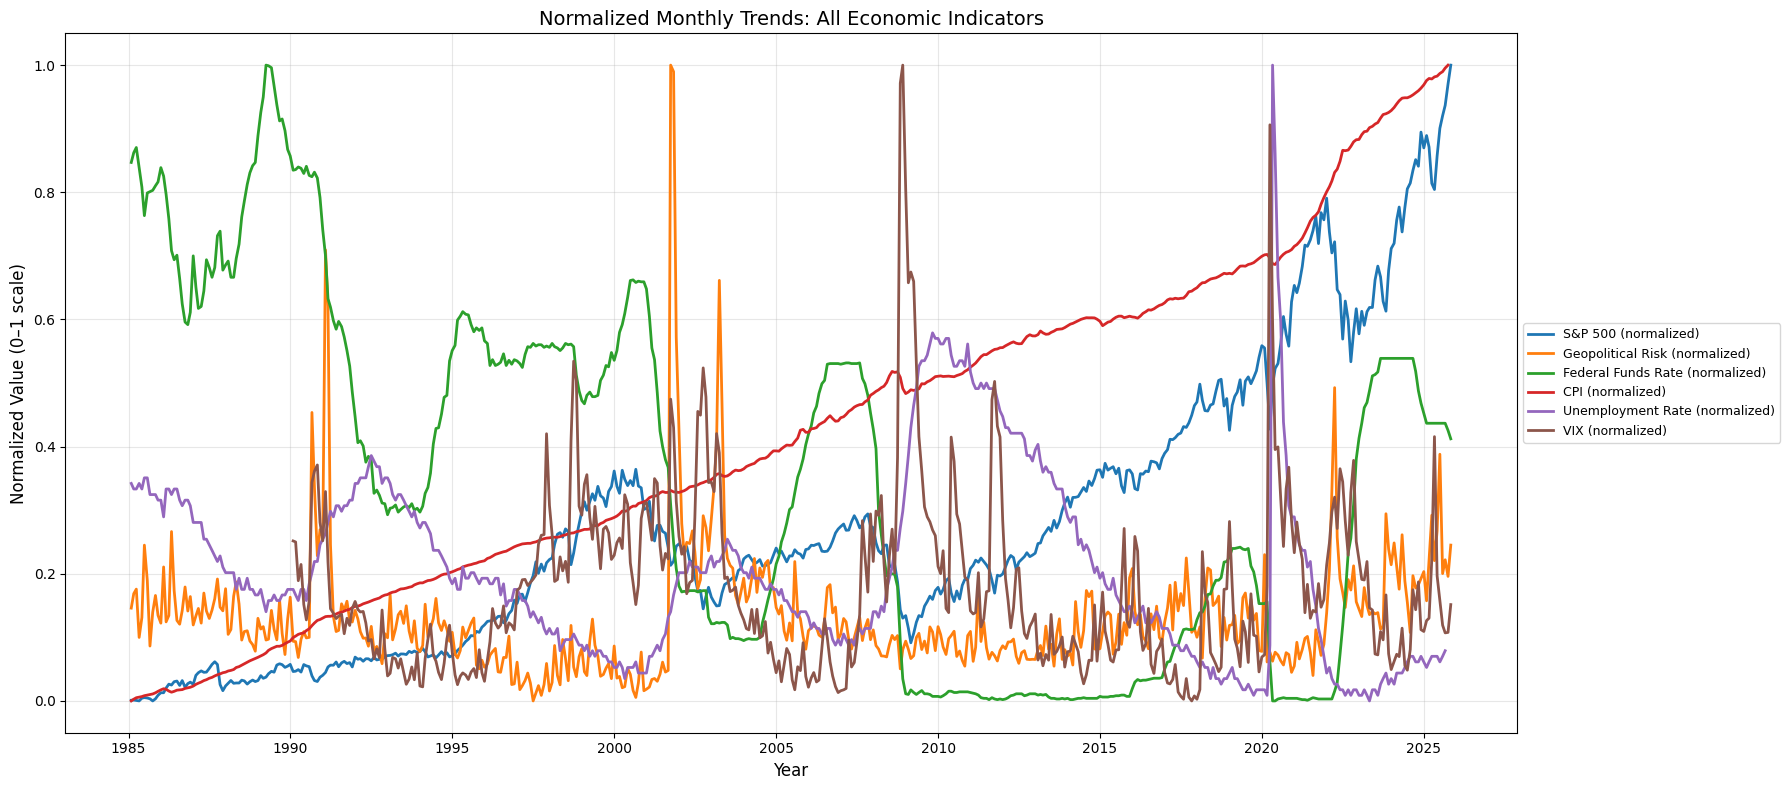

In [74]:
# Normalized graph for monthly dataset
normalized_df = merged_monthly_df.copy()

# Normalize all numeric columns
original_cols = ['SP500 Index Value ($)', 'GPRC_USA', 'FEDFUNDS', 'CPI', 'UNEMPLOYMENT RATE', 'VIX']

# Normalize original columns
for col in original_cols:
    if col in normalized_df.columns:
        normalized_df[col + '_norm'] = (
            normalized_df[col] - normalized_df[col].min()
        ) / (normalized_df[col].max() - normalized_df[col].min())

plt.figure(figsize=(18,8))
# Plot original normalized values
plt.plot(normalized_df.index, normalized_df['SP500 Index Value ($)_norm'], label='S&P 500 (normalized)', linewidth=2)
plt.plot(normalized_df.index, normalized_df['GPRC_USA_norm'], label='Geopolitical Risk (normalized)', linewidth=2)
plt.plot(normalized_df.index, normalized_df['FEDFUNDS_norm'], label='Federal Funds Rate (normalized)', linewidth=2)
if 'CPI_norm' in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df['CPI_norm'], label='CPI (normalized)', linewidth=2)
if 'UNEMPLOYMENT RATE_norm' in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df['UNEMPLOYMENT RATE_norm'], label='Unemployment Rate (normalized)', linewidth=2)
if 'VIX_norm' in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df['VIX_norm'], label='VIX (normalized)', linewidth=2)

plt.title("Normalized Monthly Trends: All Economic Indicators", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Value (0–1 scale)", fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#during spikes in GPR there are sometimes falls in the economy?
#something to investigate might be growth/loss in the SP 500 instead of just total value

## data view (After NaN processing -> If you want to delete NaN in VIX colmun)
You can check Yearly dataset -> merged_yearly_df_clean
You can check Monyhly dataset -> merged_monthly_df_clean

In [75]:
# Selective Removal - Remove rows with NaN in VIX column
# This approach minimizes data loss while ensuring VIX has complete data

# For Monthly Dataset: Remove rows where VIX is NaN
merged_monthly_df_clean = merged_monthly_df.dropna(subset=['VIX'])

# For Yearly Dataset: Remove rows where VIX is NaN
merged_yearly_df_clean = merged_yearly_df.dropna(subset=['VIX'])

# To view the datasets, uncomment the following:
# merged_monthly_df_clean
# merged_yearly_df_clean

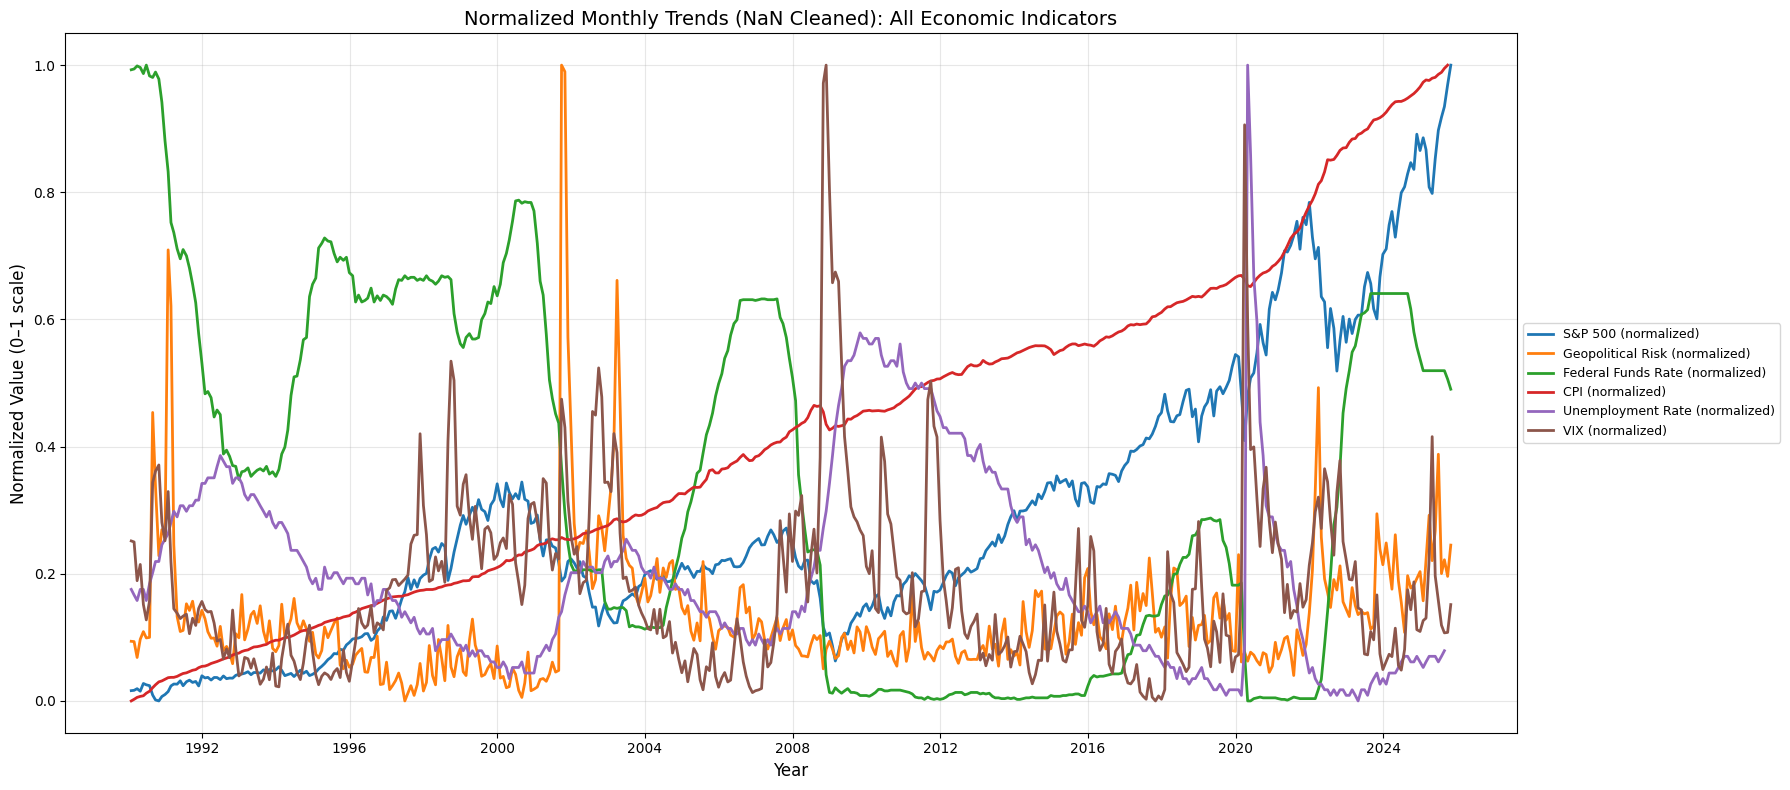

In [76]:
# Normalized graph for NaN cleaned dataset
normalized_df_clean = merged_monthly_df_clean.copy()

# Normalize all numeric columns
original_cols = ['SP500 Index Value ($)', 'GPRC_USA', 'FEDFUNDS', 'CPI', 'UNEMPLOYMENT RATE', 'VIX']

# Normalize original columns
for col in original_cols:
    if col in normalized_df_clean.columns:
        normalized_df_clean[col + '_norm'] = (
            normalized_df_clean[col] - normalized_df_clean[col].min()
        ) / (normalized_df_clean[col].max() - normalized_df_clean[col].min())

plt.figure(figsize=(18,8))
# Plot original normalized values
plt.plot(normalized_df_clean.index, normalized_df_clean['SP500 Index Value ($)_norm'], label='S&P 500 (normalized)', linewidth=2)
plt.plot(normalized_df_clean.index, normalized_df_clean['GPRC_USA_norm'], label='Geopolitical Risk (normalized)', linewidth=2)
plt.plot(normalized_df_clean.index, normalized_df_clean['FEDFUNDS_norm'], label='Federal Funds Rate (normalized)', linewidth=2)
if 'CPI_norm' in normalized_df_clean.columns:
    plt.plot(normalized_df_clean.index, normalized_df_clean['CPI_norm'], label='CPI (normalized)', linewidth=2)
if 'UNEMPLOYMENT RATE_norm' in normalized_df_clean.columns:
    plt.plot(normalized_df_clean.index, normalized_df_clean['UNEMPLOYMENT RATE_norm'], label='Unemployment Rate (normalized)', linewidth=2)
if 'VIX_norm' in normalized_df_clean.columns:
    plt.plot(normalized_df_clean.index, normalized_df_clean['VIX_norm'], label='VIX (normalized)', linewidth=2)

plt.title("Normalized Monthly Trends (NaN Cleaned): All Economic Indicators", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Value (0–1 scale)", fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [77]:
# Add CHANGE RATE columns for cleaned datasets (merged_monthly_df_clean and merged_yearly_df_clean)
import numpy as np

# Function to add CHANGE RATE columns next to each numeric column
def add_change_rate_columns(df, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []
    df_with_changes = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    new_columns = []
    for col in df.columns:
        new_columns.append(col)
        if col in numeric_cols:
            if 'SP500' in col:
                change_col_name = 'SP500 CHANGE RATE'
            elif 'GPRC_USA' in col or 'GPRC' in col:
                change_col_name = 'GPRC CHANGE RATE'
            elif 'FEDFUNDS' in col:
                change_col_name = 'FEDFUNDS CHANGE RATE'
            elif 'CPI' in col and 'CHANGE' not in col:
                change_col_name = 'CPI CHANGE RATE'
            elif 'UNEMPLOYMENT' in col or 'UNRATE' in col:
                change_col_name = 'UNEMPLOYMENT RATE CHANGE RATE'
            elif 'VIX' in col and 'CHANGE' not in col:
                change_col_name = 'VIX CHANGE RATE'
            elif 'GDP' in col:
                change_col_name = 'GDP CHANGE RATE'
            else:
                change_col_name = col.replace(' Index Value ($)', ' CHANGE RATE').replace(' ($)', ' CHANGE RATE').replace('_', ' ').title().replace(' ', ' ') + ' CHANGE RATE'
            df_with_changes[change_col_name] = df[col].pct_change(fill_method=None) * 100
            new_columns.append(change_col_name)
    df_with_changes = df_with_changes[new_columns]
    return df_with_changes

# Apply to cleaned datasets
merged_monthly_df_clean_with_changes = add_change_rate_columns(merged_monthly_df_clean, exclude_cols=['date_month'])
merged_yearly_df_clean_with_changes = add_change_rate_columns(merged_yearly_df_clean, exclude_cols=['Year'])

# To view the datasets, uncomment the following:
# merged_monthly_df_clean_with_changes
# merged_yearly_df_clean_with_changes
